<div class="alert alert-block alert-success">
    <b>ARTIFICIAL INTELLIGENCE (E016350A)</b> <br>
ALEKSANDRA PIZURICA <br>
GHENT UNIVERSITY <br>
AY 2024/2025 <br>
Assistant: Niels Vyncke
</div>

# Introduction to Principal Component Analysis (PCA)

In this notebook, we’ll cover the fundamentals of Principal Component Analysis (PCA). We’ll begin by explaining PCA and manually implementing its main steps. Then, we’ll explore the `PCA` module in Scikit-learn and apply PCA to various synthetic datasets as well as the Iris dataset

First, let's import the necessary modules for this notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs, make_swiss_roll, load_iris
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.manifold import Isomap, TSNE
from scipy.stats import mode

## Introduction to PCA

**Principal Component Analysis (PCA)** is a dimensionality reduction technique commonly used in data preprocessing and exploratory data analysis. It works by transforming data into a new set of orthogonal (uncorrelated) axes, capturing the most significant patterns with the fewest dimensions necessary.

Some key properties of Principal Component Analysis are:

- PCA creates **uncorrelated (orthogonal) features**, which represent independent axes in the transformed space.
- PCA identifies **principal components** in the input space, ordering these components by their explained variance, so that components with the highest variance appear first.
- PCA is a **linear transformation** technique, so it cannot capture non-linear relationships between features.

### How to perform Principal Component Analysis?
1. **Calculate the covariance matrix:** This matrix represents the relationships between features.
2. **Perform eigen decomposition:** Find the eigenvalues and eigenvectors of the covariance matrix.
3. **Sort eigenvectors by eigenvalues:** Select eigenvectors with the highest eigenvalues as the principal components.
4. **Project data:** Transform the data onto the selected principal components to reduce dimensionality.

It is recommended to perform feature normalization (`StandardScaler`) before applying PCA. 

### PCA implementation

In this section, we implement PCA from scratch.

### Step 0: Data Standardization

First, the features are standardized to have zero mean and unit variance:

$$x'=\frac{x-\mu}{\sigma}$$

In [2]:
def standardize_data(X):
    """
    Standardizes the dataset X by centering to zero mean and scaling to unit variance.
    
    Args:
        X (np.ndarray): Input data matrix of shape (n_samples, n_features)
    
    Returns:
        np.ndarray: Standardized data
    """
    mean = np.mean(X, axis=0)
    std_dev = np.std(X, axis=0)
    X_standardized = (X - mean) / std_dev
    return X_standardized

### Step 1: Covariance Matrix Calculation

Secondly the covariance matrix $\Sigma$ is computed as follows:

$$\Sigma = \frac{1}{N-1} \mathbf{X}^\top \mathbf{X},$$

with $N$ the number of data samples.

In [3]:
def calculate_covariance_matrix(X):
    """
    Calculates the covariance matrix for standardized data X.
    
    Args:
        X (np.ndarray): Standardized data matrix of shape (n_samples, n_features)
    
    Returns:
        np.ndarray: Covariance matrix of shape (n_features, n_features)
    """
    n_samples = X.shape[0]
    cov_matrix = np.dot(X.T, X) / (n_samples - 1)
    return cov_matrix


### Step 2: Eigen Decomposition

The principal components are computed using the Eigen decomposition of the covariance matrix $\Sigma$.

$$\mathbf{\Sigma}=\mathbf{\mathcal{Q}}\mathbf{\Lambda}\mathbf{\mathcal{Q}}^\top,$$

with $\mathcal{Q}$ the matrix of Eigenvectors and $\Lambda$ the vector of Eigenvalues.


In [4]:
def eigen_decomposition(cov_matrix):
    """
    Performs eigen decomposition on the covariance matrix.
    
    Args:
        cov_matrix (np.ndarray): Covariance matrix of shape (n_features, n_features)
    
    Returns:
        tuple: eigenvalues and eigenvectors
    """
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    return eigenvalues, eigenvectors


### Step 3: Sorting Eigenvalues and Eigenvectors

In PCA, we only retain the principal components that explain the most variance. The Eigenvalues are sorted in descending order, and the Eigenvectors accordingly.

In [5]:
def sort_eigenvalues_eigenvectors(eigenvalues, eigenvectors):
    """
    Sorts eigenvalues and their corresponding eigenvectors in descending order.
    
    Args:
        eigenvalues (np.ndarray): Array of eigenvalues
        eigenvectors (np.ndarray): Matrix of eigenvectors
    
    Returns:
        tuple: Sorted eigenvalues and eigenvectors
    """
    idx = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[idx]
    sorted_eigenvectors = eigenvectors[:, idx]
    return sorted_eigenvalues, sorted_eigenvectors


### Step 4: Project Data onto Principal Components
Write a function to reduce the dimensionality of the dataset by projecting it onto the top k principal components.

In [6]:
def project_data(X, eigenvectors):
    """
    Projects the data onto the top k eigenvectors.
    
    Args:
        X (np.ndarray): Standardized data
        eigenvectors (np.ndarray): Matrix of eigenvectors
        k (int): Number of principal components to retain
    
    Returns:
        np.ndarray: Transformed data with reduced dimensions
    """
    return np.dot(X, eigenvectors)


### Example 1: Ellipse-shaped dataset

We create a synthetic dataset consisting of a 2D ellipse shape, projected into a 3D space. We apply PCA to extract the 2D ellipse from this 3D space.

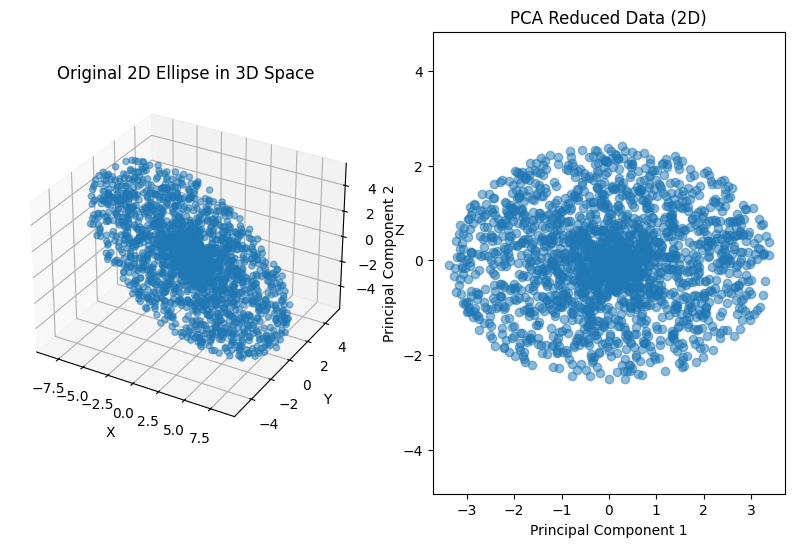

In [7]:
# Generate a 2D ellipse in the XY-plane
num_points = 2000
theta = np.random.random(num_points) * 2 * np.pi # Angle for the ellipse
r = np.random.random(num_points)
a, b = 10, 5  # Semi-major and semi-minor axes of the ellipse

x = r * a * np.cos(theta)  # X coordinates of the ellipse
y = r * b * np.sin(theta)  # Y coordinates of the ellipse
z = np.random.normal(0, 0.1, num_points)  # Z coordinates normal distributed with 0 mean and 0.1 variance

ellipse_2D = np.vstack((x, y, z)).T  # Stack them into a (n_points, 3) array

# Apply a hardcoded 3D rotation to map the 2D ellipse onto a random plane
# Define a fixed random rotation by choosing a random axis and angle
angle = np.pi / 6   # A fixed rotation angle (e.g., 30 degrees)

# Randomly choose a rotation axis, for example rotating around the Y-axis and X-axis
rotation_matrix = np.array([
    [np.cos(angle), 0, np.sin(angle)],  # Rotation about the Y-axis
    [0, 1, 0],
    [-np.sin(angle), 0, np.cos(angle)]  # Rotation about the Z-axis
])

# Apply the rotation to the 2D ellipse to map it into 3D
X_3D_ellipse = np.dot(ellipse_2D, rotation_matrix.T)  # Apply the rotation to the points

# Visualize original 3D filled ellipse
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(X_3D_ellipse[:, 0], X_3D_ellipse[:, 1], X_3D_ellipse[:, 2], alpha=0.5)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Original 2D Ellipse in 3D Space")

# Standardize data
X_standardized_3D = standardize_data(X_3D_ellipse)

# Perform PCA
cov_matrix_ellipse = calculate_covariance_matrix(X_standardized_3D)
eigenvalues_ellipse, eigenvectors_ellipse = eigen_decomposition(cov_matrix_ellipse)

# Sort and project data onto the first two principal components
idx = np.argsort(eigenvalues_ellipse)[::-1]
sorted_eigenvectors_ellipse = eigenvectors_ellipse[:, idx]
X_reduced_ellipse = project_data(X_standardized_3D, sorted_eigenvectors_ellipse)

# Visualize PCA-reduced data
ax2 = fig.add_subplot(122)
ax2.scatter(X_reduced_ellipse[:, 0], X_reduced_ellipse[:, 1], alpha=0.5)
ax2.set_xlabel("Principal Component 1")
ax2.set_ylabel("Principal Component 2")
ax2.set_title("PCA Reduced Data (2D)")
plt.axis('equal')
plt.show()


#### Vizualize the principal components

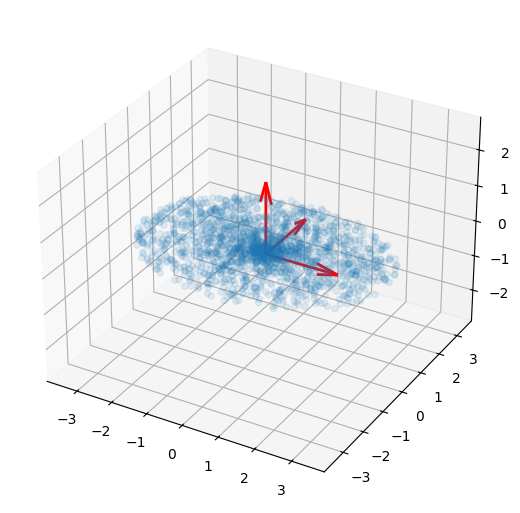

In [8]:
# %matplotlib notebook

fig = plt.figure(figsize=(14, 7))

ax = fig.add_subplot(121, projection='3d')
ax.scatter(X_reduced_ellipse[:, 0], X_reduced_ellipse[:, 1], X_reduced_ellipse[:, 2], alpha=0.1)

# Plot the principal components as arrows in the 3D plot
mean_ellipse = np.mean(X_3D_ellipse, axis=0)  # Calculate the centroid of the data
scale = 2  # Scale factor for the eigenvectors' length
for i in range(3):
    ax.quiver(mean_ellipse[0], mean_ellipse[1], mean_ellipse[2], 
              (i == 0) * scale,
              (i == 1) * scale,
              (i == 2) * scale,
              color='r', linewidth=2)

ax.axis('equal')
plt.show()

As you can see, PCA identifies both axes of the ellipse as the principal components and we can extract the ellipse.

## Comparison with Scikit-Learn’s PCA

Scikit-learn also provides a function to perform Principal Component Analysis:
    

    sklearn.decomposition.PCA


### Core Parameters of `PCA`:

* `n_components`: This parameter defines the number of principal components to keep. It can be set as:
    - An integer (`n_components=k`), meaning that PCA will reduce the data to $k$ dimensions.
    - A float between $0$ and $1$ (e.g., `n_components=0.95`), meaning that PCA will select the smallest number of components that explain at least $95\%$ of the variance in the data.
    - If `None`, all components are kept, and no dimensionality reduction occurs.

* `svd_solver`: Specifies the algorithm used to compute the principal components. Options are:

    - `'auto'`: Automatically selects the solver based on data shape.
    - `'full'`: Uses a complete Singular Value Decomposition (SVD).
    - `'arpack'`: Uses a truncated SVD for large datasets.
    - `'randomized'`: A fast approximation of SVD useful for large datasets.

* `whiten`: If `True`, this option scales the principal components to have unit variance. Whitening can be useful when principal components need to be uncorrelated and have equal importance, such as in some machine learning models.

* `random_state`: Used when `svd_solver='randomized'` to control the randomness of the SVD initialization for reproducibility.

Let's now compare our implementation with scikit-learn's implementation.

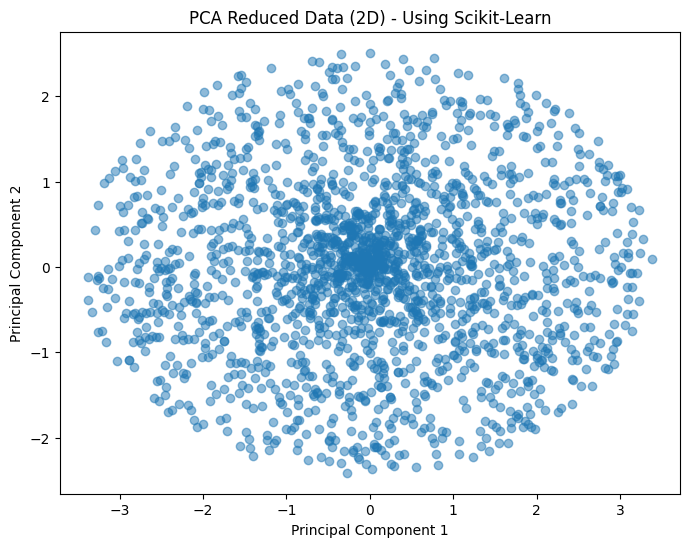

In [9]:
pca = PCA(n_components=2)
X_reduced_sklearn = pca.fit_transform(X_standardized_3D) # PCA on standardized features!

plt.figure(figsize=(8, 6))
plt.scatter(X_reduced_sklearn[:, 0], X_reduced_sklearn[:, 1], alpha=0.5)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Reduced Data (2D) - Using Scikit-Learn")
plt.show()

As you can see, both implementations result in the same graph.

## A real-world dataset

### Example 2: The Iris Dataset

In this example, we perform dimensionality reduction on the Iris dataset. We can perform dimensionality reduction by using the 2 principal components that explain most of the dataset variance.

Explained variance by each component: [0.72962445 0.22850762]
Total explained variance: 0.9581320720000165


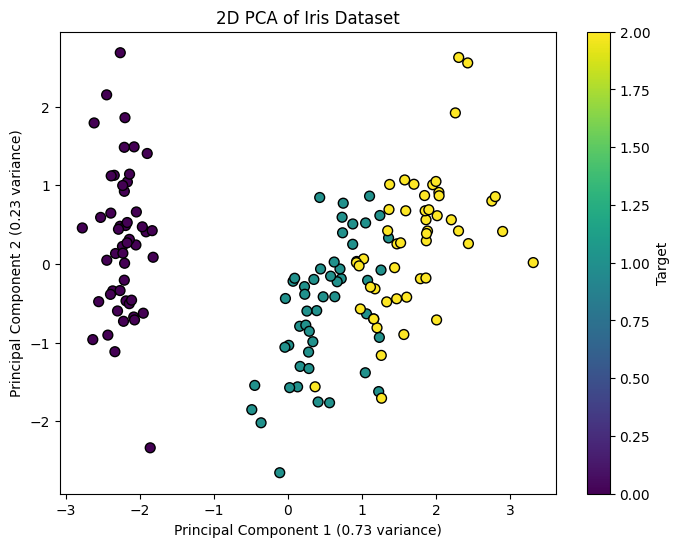

PCA Components (Feature Loadings):
     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
PC1           0.521066         -0.269347           0.580413          0.564857
PC2           0.377418          0.923296           0.024492          0.066942
Reconstructed Data (approximation of the original):
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0          -0.998889          1.053198          -1.302707         -1.247098
1          -1.338748         -0.061923          -1.224328         -1.220572
2          -1.360961          0.321117          -1.380603         -1.358338
3          -1.423598          0.067762          -1.349224         -1.338813
4          -1.001138          1.240918          -1.371254         -1.306618


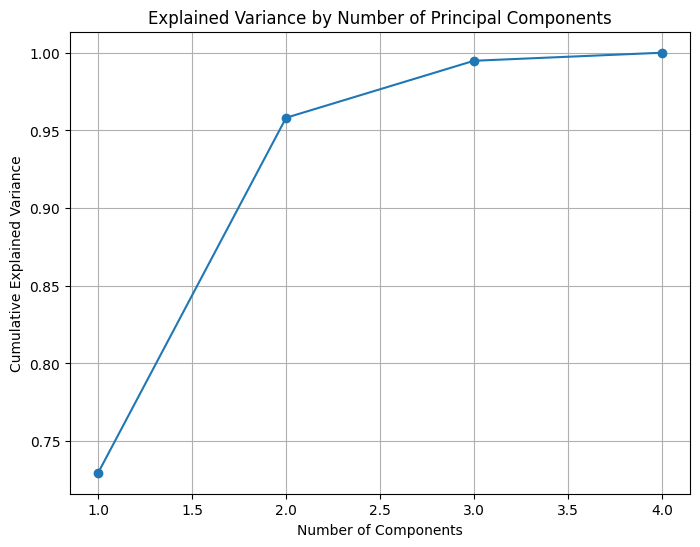

In [10]:
# Step 1: Load the Data
# We'll use the Iris dataset, a common dataset for practicing PCA.
data = load_iris()
X = data.data
y = data.target
feature_names = data.feature_names

# Convert to a DataFrame for easier handling
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

# Display the first few rows of the data
df.head()

# Step 2: Data Standardization
# PCA is affected by scale, so we need to standardize the data to have a mean of 0 and variance of 1.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Perform PCA
# We'll set n_components=2 to reduce the dataset to 2 principal components for easy visualization.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Step 4: Understanding the Explained Variance
# Let's see how much variance each principal component explains.
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by each component: {explained_variance}")
print(f"Total explained variance: {sum(explained_variance)}")

# Step 5: Visualize the Results
# Plotting the data in the new 2D PCA space.
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k', s=50)
plt.xlabel(f'Principal Component 1 ({explained_variance[0]:.2f} variance)')
plt.ylabel(f'Principal Component 2 ({explained_variance[1]:.2f} variance)')
plt.title('2D PCA of Iris Dataset')
plt.colorbar(label='Target')
plt.show()

# Step 6: Interpreting PCA Components
# We can see the contribution (loading) of each original feature to the principal components.
# This helps us understand how each original feature contributes to each principal component.
pca_components = pd.DataFrame(pca.components_, columns=feature_names, index=[f'PC1', f'PC2'])
print("PCA Components (Feature Loadings):")
print(pca_components)

# Step 7: Reconstructing the Original Data (optional)
# We can also reconstruct the original data from the principal components to approximate the original dataset.
X_reconstructed = pca.inverse_transform(X_pca)
df_reconstructed = pd.DataFrame(X_reconstructed, columns=feature_names)
print("Reconstructed Data (approximation of the original):")
print(df_reconstructed.head())

# Step 8: Experimenting with Different Numbers of Components (optional)
# Try different values of n_components and observe the explained variance to decide the optimal number of components.
pca_full = PCA().fit(X_scaled)
explained_variance_full = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_full) + 1), explained_variance_full, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Principal Components')
plt.grid()
plt.show()

Now, we cluster the two principal components using $k$-means clustering.

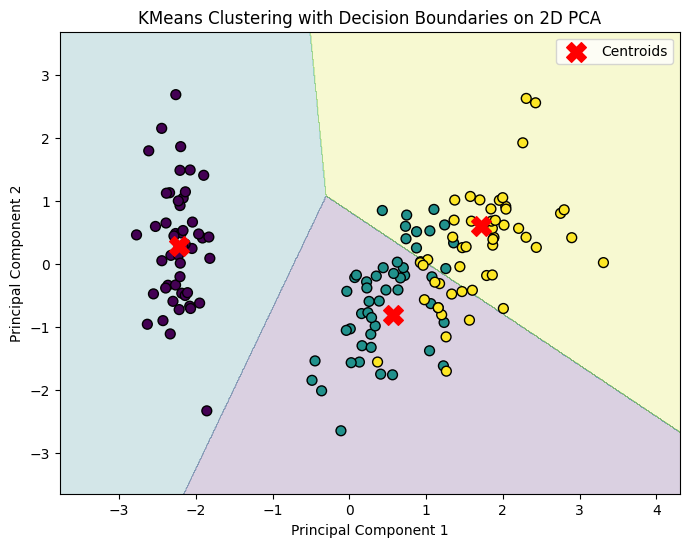

Accuracy of KMeans clustering: 83.33%


In [11]:
# Define a function to match each cluster label to the true label
def calculate_accuracy(true_labels, kmeans_labels, n_clusters):
    # Find the unique clusters
    labels = np.zeros_like(kmeans_labels)
    for i in range(n_clusters):  # Number of clusters
        mask = (kmeans_labels == i)
        # Assign the most common true label in each cluster as the label for that cluster
        labels[mask] = mode(true_labels[mask], keepdims=True)[0]
    return accuracy_score(true_labels, labels)
    
def plot_kmeans(X, y, n_clusters):
# Fit KMeans on the PCA-transformed data
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=0)
    kmeans.fit(X)
    
    # Create a mesh grid covering the range of transformed data
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # Use KMeans model to predict on the grid
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundaries and the original data points
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap='viridis', alpha=0.2)  # Boundary regions
    
    # Scatter plot of the transformed data with true labels
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', s=50)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                s=200, c='red', marker='X', label='Centroids')  # KMeans centroids
    
    plt.xlabel(f'Principal Component 1')
    plt.ylabel(f'Principal Component 2')
    plt.title(f'KMeans Clustering with Decision Boundaries on 2D PCA')
    plt.legend()
    plt.show()
    
    kmeans_labels = kmeans.predict(X_pca)
    
    # Calculate accuracy
    accuracy = calculate_accuracy(y, kmeans_labels, n_clusters)
    print(f"Accuracy of KMeans clustering: {accuracy * 100:.2f}%")

plot_kmeans(X_pca, y, 3)

## Some synthetic datasets

Let's now look at some other synthetic datasets to see how PCA performs.

In [12]:
# Function for plotting 2D clusters
def plot_2d_clusters(X, y, title):
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', s=50)
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.axis('equal')
    plt.show()

In [13]:
# Function for 3D plotting
def plot_3d_clusters(X, y, title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='viridis', s=50)
    ax.set_title(title)
    plt.axis('equal')
    plt.show()

### Example 3: High-Dimensional Gaussian Clusters

A simple example is a high-dimensional dataset of Gaussian clusters. Here, we use a $12$-dimensional dataset containing 5 clusters. Depending on the number of clusters and features, PCA works fairly well as a clustering technique. However, this becomes more difficult with more clusters and fewer dimensions.

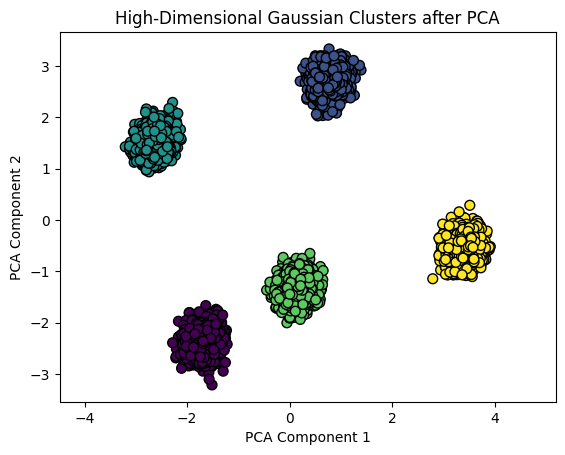

In [14]:
X, y = make_blobs(n_samples=10000, centers=5, n_features=12, random_state=42)
pca = PCA(n_components=2)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_pca = pca.fit_transform(X)
plot_2d_clusters(X_pca, y, "High-Dimensional Gaussian Clusters after PCA")

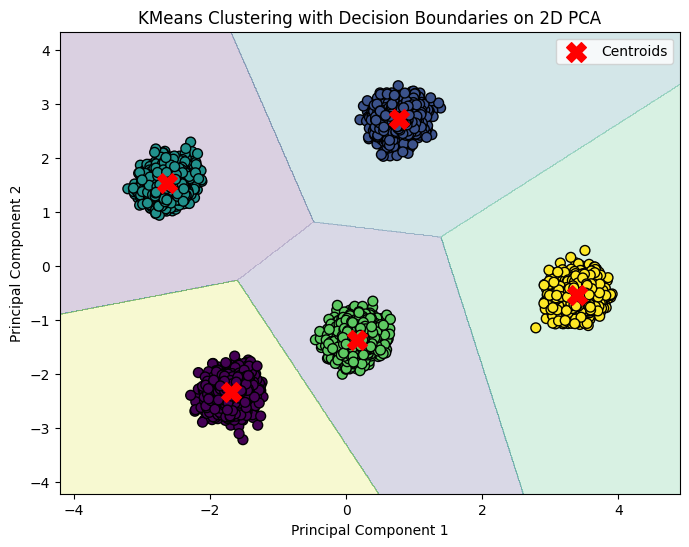

Accuracy of KMeans clustering: 100.00%


In [15]:
plot_kmeans(X_pca, y, 5)

Let's try a more "difficult" example now.

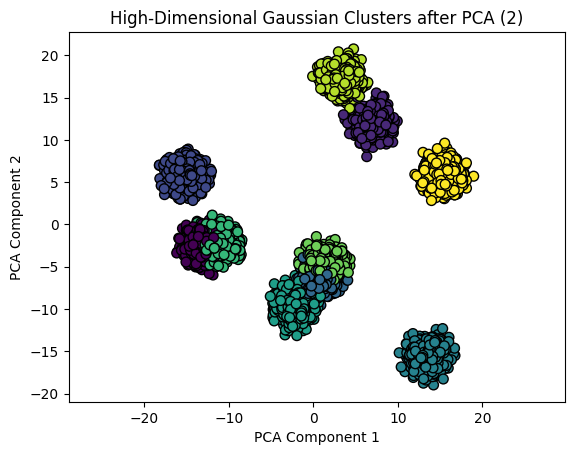

In [16]:
X, y = make_blobs(n_samples=10000, centers=10, n_features=12, random_state=42)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plot_2d_clusters(X_pca, y, "High-Dimensional Gaussian Clusters after PCA (2)")

With PCA, we cannot fully separate the Gaussian clusters in this case, we will demonstrate a non-linear techniuqe like t-SNE.

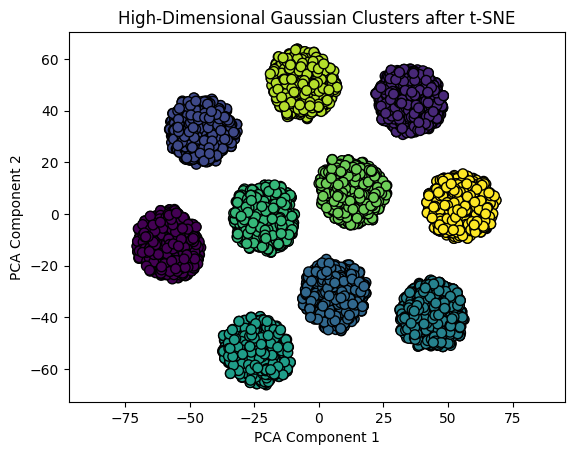

In [17]:
tsne = TSNE()

X_tsne = tsne.fit_transform(X)

plot_2d_clusters(X_tsne, y, "High-Dimensional Gaussian Clusters after t-SNE")

### Example 4: Swiss Roll Dataset

When applying PCA to the Swiss roll dataset, we can eliminate the depth dimension. To "unroll" the structure, we need some more sophisticated non-linear methods, like isomap.

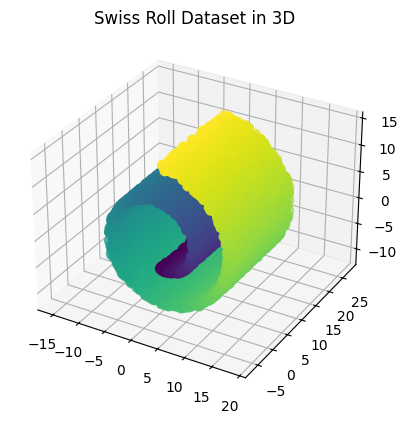

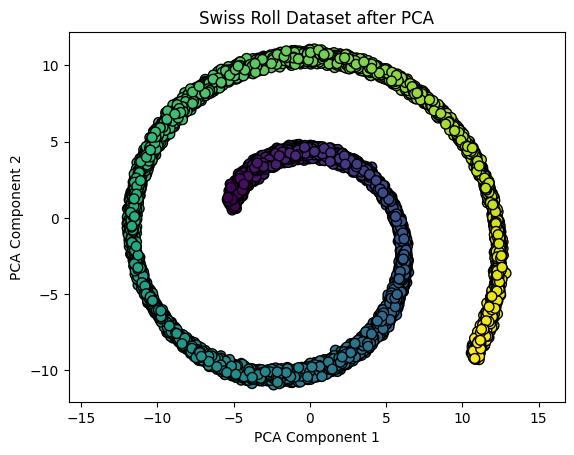

In [18]:
X, y = make_swiss_roll(n_samples=10000, noise=0.1, random_state=42)
# Visualize original 3D data
plot_3d_clusters(X, y, "Swiss Roll Dataset in 3D")
# Apply PCA and visualize in 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plot_2d_clusters(X_pca, y, "Swiss Roll Dataset after PCA")

As you can see, a linear technique like PCA does not unroll the structure. We will demonstrate a non-linear technique like `Isomap`.

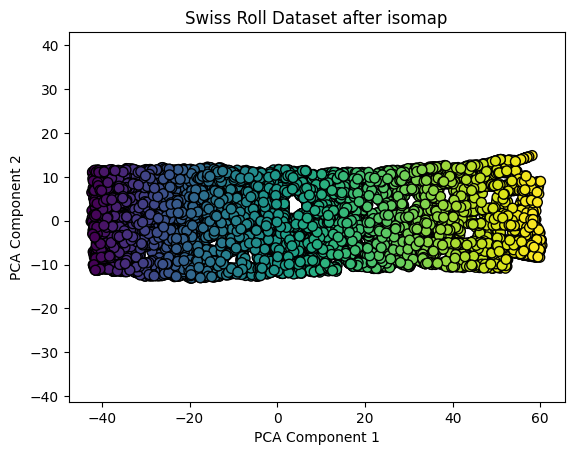

In [19]:
isomap = Isomap()

X_isomap = isomap.fit_transform(X)

plot_2d_clusters(X_isomap, y, "Swiss Roll Dataset after isomap")

As you can see, we successfully unrolled the Swiss roll structure.

## Summary of Principal Component Analysis

We have demonstrated PCA to several datasets. We have shown that:

- PCA finds **principal components** inside the dataset.
- PCA is a **dimensionality reduction** technique that can be used for clustering (e.g. together with k-means).
- PCA is a **linear technique** and cannot be applied in any use case.

After completing this notebook, you should know how PCA works and how to use Scikit-learn to apply PCA to a given dataset.